# This program classifies the trade agreement using Fastai ULM-FIT
### Follow [imdb.ipynb](http://127.0.0.1:8888/notebooks/dropbox/workslot/mypython/WorldBank_project/imdb.ipynb)  ([Fastai Lesson 10](https://www.youtube.com/watch?time_continue=548&v=h5Tz7gZT9Fo))

In [ ]:
# from sklearn.datasets import fetch_20newsgroups
# twenty_train = fetch_20newsgroups(subset='train', shuffle=True)

In [139]:
from fastai.text import *
import html
PATH=Path('/Users/renjiege/Documents/data/fastai/aclImdb/')


path = "/Users/renjiege/Dropbox/DEEP PTA - SEC2/quantification/sec2_parse"
file = 'test.dta'
full_file = os.path.join(path, file)
df = pd.read_stata(full_file)

In [71]:
import numpy as np
df = df.filter(items=['TypeofRestriction', 'MeasureText'])
df['type1'] = Series(df.TypeofRestriction.str.contains('MFN', regex=True))
df['type1_num'] = np.where(df['type1']==True,1,0)

In [72]:
tab(df.type1,'')

type1
False    1519
True      655
Name: __dummy__, dtype: int64

In [73]:
x_train, x_test, y_train, y_test = train_test_split(df.MeasureText, df.type1_num, test_size=0.2, random_state=4)

In [74]:
CLAS_PATH = Path('/Users/renjiege/Documents/data/fastai/imdb_clas/')
LM_PATH = Path('/Users/renjiege/Documents/data/fastai/imdb_lm/')

In [75]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag
CLASSES = ['neg', 'pos', 'unsup']
col_names = ['labels','text']
df_trn = pd.DataFrame({'text':x_train, 'labels':y_train}, columns=col_names)
df_val = pd.DataFrame({'text':x_test, 'labels':y_test}, columns=col_names)

df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

(CLAS_PATH/'classes.txt').open('w', encoding='utf-8').writelines(f'{o}\n' for o in CLASSES)

In [76]:
df_trn = pd.DataFrame({'text':x_train, 'labels':[0]*len(x_train)}, columns=col_names)
df_val = pd.DataFrame({'text':x_test, 'labels':[0]*len(x_test)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

In [77]:
chunksize=24000

In [78]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [79]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [80]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [81]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [83]:
df_val

In [84]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
0


In [85]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [88]:
' '.join(tok_trn[130])

'\n xbos xfld 1 " western australia \n\n a natural person ( whether alone or in partnership with other persons ) or an incorporated body seeking to carry on a business of providing credit in western australia ( including where the provision of the credit is connected with the carrying on of another business ) , must have a principal office in australia and a principal place of business in western australia . \n\n any person ( including an incorporated body ) seeking to exercise or carry on the business or any functions of a debt collector in western australia , must have a principal place of business in the state . \n\n a natural person seeking to carry on business as a finance broker in western australia must be ordinarily resident in western australia . a finance broker must have a registered office in western australia while carrying on business as a broker . "'

In [89]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [90]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [91]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[(',', 8947),
 ('the', 7951),
 ('.', 6306),
 ('of', 6274),
 ('a', 4920),
 ('de', 4914),
 ('in', 4564),
 ('to', 4196),
 ('or', 4187),
 ('and', 3909),
 ('\n\n', 3638),
 ('"', 3304),
 ('\n', 3288),
 (')', 3095),
 ('(', 2915),
 ('1', 2060),
 ('services', 1935),
 ('-', 1874),
 ('xbos', 1739),
 ('xfld', 1739),
 ('be', 1695),
 ('y', 1601),
 ('en', 1538),
 ('for', 1472),
 ('by', 1434)]

In [93]:
max_vocab = 60000
min_freq = 2

In [94]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [95]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

4363

In [96]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [97]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [98]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [241]:
stem_vectorizer.fit(df.MeasureText)
x_train_tf = stem_vectorizer.transform(x_train)
x_test_tf = stem_vectorizer.transform(x_test)
text_clf = MultinomialNB().fit(x_train_tf, y_train)

In [99]:
vs=len(itos)
vs,len(trn_lm)

(4363, 1739)

In [100]:
em_sz,nh,nl = 400,1150,3

In [103]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [104]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [105]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [106]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [107]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [108]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

Model

In [109]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [110]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [111]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [112]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [113]:
learner.model.load_state_dict(wgts)

In [114]:
lr=1e-3
lrs = lr

In [115]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      5.080242   4.685488   0.2423    



[array([4.68549]), 0.24229967113178788]

In [116]:
learner.save('lm_last_ft')

In [117]:
learner.load('lm_last_ft')

In [118]:
learner.unfreeze()

In [119]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

  2%|▏         | 1/63 [00:20<20:46, 20.10s/it, loss=5.08]

KeyboardInterrupt: 

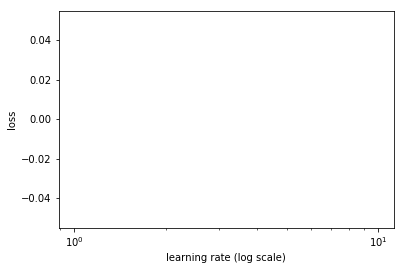

In [120]:
learner.sched.plot()

In [ ]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

In [121]:
learner.save('lm1')

In [122]:
learner.save_encoder('lm1_enc')

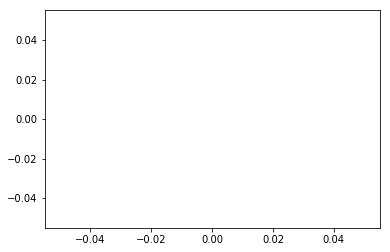

In [123]:
learner.sched.plot_loss()

Classifier Token

In [124]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [125]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
0


In [126]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [127]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [128]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

4363

In [129]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [130]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

Classification

In [131]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [132]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [133]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [134]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [135]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [136]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [141]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [142]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [143]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.25
learn.metrics = [accuracy]

In [144]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [145]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [146]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')

In [147]:
learn.freeze_to(-1)

 89%|████████▉ | 65/73 [05:10<00:40,  5.05s/it, loss=2.81] 

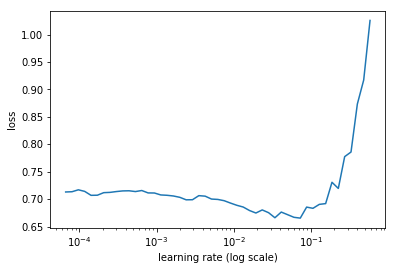

In [148]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [149]:
learn.unfreeze()

In [ ]:
learn.fit(lrs, 1, wds=wd, cycle_len=3, use_clr=(32,10))